# Data Analysis - Survival Analysis

RNA data from: https://xenabrowser.net/datapages/?cohort=GDC%20Pan-Cancer%20(PANCAN)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443   

Phenotype data from: https://xenabrowser.net/datapages/?dataset=GDC-PANCAN.basic_phenotype.tsv&host=https%3A%2F%2Fgdc.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443   

Survival data from: https://xenabrowser.net/datapages/?dataset=GDC-PANCAN.survival.tsv&host=https%3A%2F%2Fgdc.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

### Transfer CSV files to Parquet

---

For faster file read-in

In [20]:
# Read in the csv into a df
# df_transfer = pd.read_csv('./data/GDC-PANCAN.htseq_fpkm-uq.tsv', sep='\t')
# df_survival_transfer = pd.read_csv('./data/GDC-PANCAN.survival.tsv', sep='\t')
# df_basic_pheno_transfer = pd.read_csv('./data/GDC-PANCAN.basic_phenotype.tsv', sep='\t')

# Transform csv's into parquet files
# df_transfer.to_parquet('./data/GDC-PANCAN.htseq_fpkm-uq.parquet', compression=None)
# df_survival_transfer.to_parquet('./data/GDC-PANCAN.survival.parquet', compression=None)
# df_basic_pheno_transfer.to_parquet('./data/GDC-PANCAN.basic_phenotype.parquet', compression=None)

### TCGA Barcodes
The column headers are TCGA barcodes:
* In the format of: `project-tissuesourcesite-participant-sample|vial-portion|analyte-plate-center`
* https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/
* https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tissue-source-site-codes

In [2]:
# Installations
# !pip install kaplanmeier
# !pip install gseapy
# !pip install statsmodels # for hazard ratio calculations

In [1]:
# Imports
import pandas as pd

In [2]:
# Read in the RNA matrix
df = pd.read_parquet('./data/GDC-PANCAN.htseq_fpkm-uq.parquet')
display(df.head())

,xena_sample,TCGA-OR-A5JP-01A,TCGA-OR-A5JE-01A,TCGA-OR-A5JG-01A,TCGA-OR-A5L9-01A,TCGA-OR-A5JR-01A,TCGA-OR-A5KU-01A,TCGA-OR-A5LS-01A,TCGA-OR-A5J7-01A,TCGA-OR-A5JQ-01A,...,TARGET-50-PAJMKJ-01A,TARGET-50-CAAAAQ-11A,TARGET-50-PAKSCC-01A,TARGET-50-PAJNSL-11A,TARGET-50-PAJPAU-01A,TARGET-50-PAJNZU-01A,TARGET-50-PAJNNR-01A,TARGET-50-PAJNTJ-02A,TARGET-50-PAECJB-01A,TARGET-50-PALFRD-01A
0,ENSG00000242268.2,0.000000,0.000000,0.000000,0.000000,9.486642,0.000000,0.000000,0.000000,0.000000,...,11.700035,10.041859,13.398458,0.000000,10.617230,11.933609,14.140998,11.659218,10.662028,12.878131
1,ENSG00000270112.3,10.689655,14.408626,14.022621,11.291444,10.221394,12.423503,12.830424,12.758888,11.547426,...,9.267574,12.513257,10.501003,10.452072,10.625798,8.310776,7.131909,7.678919,10.134942,11.116645
2,ENSG00000167578.15,18.536987,18.684183,17.334107,19.713465,16.761630,17.762472,18.114361,19.068519,17.474470,...,15.541309,16.684341,15.905948,16.991286,15.066989,13.953978,15.969451,14.607776,14.387707,15.886538
3,ENSG00000273842.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ENSG00000078237.5,17.847476,18.227483,17.287893,16.722624,17.157762,17.001996,18.648729,18.076084,15.817248,...,15.377730,16.438256,16.733394,16.149538,16.277784,15.673957,16.305087,15.916629,15.850915,16.188748


### Align RNA / OS / Phenotype samples

---

In [3]:
# Read in ID/Gene Mapping file
mapping_df = pd.read_csv('./data/gencode.v22.annotation.gene.probeMap', sep='\t')
display(mapping_df.head())

,id,gene,chrom,chromStart,chromEnd,strand
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,+
1,ENSG00000227232.5,WASH7P,chr1,14404,29570,-
2,ENSG00000278267.1,MIR6859-3,chr1,17369,17436,-
3,ENSG00000243485.3,RP11-34P13.3,chr1,29554,31109,+
4,ENSG00000274890.1,MIR1302-9,chr1,30366,30503,+


In [4]:
# Check to see if the mapping file and the rna matrix file have the same id names
mapping_df.rename(columns={'id': 'xena_sample'}, inplace=True)
merged_df = pd.merge(mapping_df, df, on='xena_sample', how='outer', indicator=True)

# Check matching status
# Filter rows that do not have 'both' in the '_merge' column
non_matching_rows = merged_df[merged_df['_merge'] != 'both']

# Print the non-matching rows
print(non_matching_rows)

Empty DataFrame
Columns: [xena_sample, gene, chrom, chromStart, chromEnd, strand, TCGA-OR-A5JP-01A, TCGA-OR-A5JE-01A, TCGA-OR-A5JG-01A, TCGA-OR-A5L9-01A, TCGA-OR-A5JR-01A, TCGA-OR-A5KU-01A, TCGA-OR-A5LS-01A, TCGA-OR-A5J7-01A, TCGA-OR-A5JQ-01A, TCGA-OR-A5JS-01A, TCGA-OR-A5JL-01A, TCGA-OR-A5LC-01A, TCGA-OR-A5K2-01A, TCGA-P6-A5OG-01A, TCGA-OR-A5JW-01A, TCGA-OR-A5JZ-01A, TCGA-OR-A5J8-01A, TCGA-OR-A5K5-01A, TCGA-OR-A5KV-01A, TCGA-OR-A5L4-01A, TCGA-OR-A5KX-01A, TCGA-OR-A5K1-01A, TCGA-OR-A5JO-01A, TCGA-OR-A5LG-01A, TCGA-OR-A5LO-01A, TCGA-OR-A5JB-01A, TCGA-OR-A5JV-01A, TCGA-OR-A5LJ-01A, TCGA-OR-A5LA-01A, TCGA-OR-A5KY-01A, TCGA-OR-A5KO-01A, TCGA-OR-A5L6-01A, TCGA-OR-A5KZ-01A, TCGA-OR-A5J5-01A, TCGA-OR-A5LB-01A, TCGA-OR-A5LT-01A, TCGA-OR-A5LD-01A, TCGA-OR-A5J2-01A, TCGA-OR-A5LE-01A, TCGA-OR-A5K4-01A, TCGA-OR-A5K6-01A, TCGA-OR-A5JY-01A, TCGA-OR-A5JT-01A, TCGA-OR-A5KW-01A, TCGA-PK-A5H8-01A, TCGA-OR-A5JX-01A, TCGA-OR-A5LK-01A, TCGA-P6-A5OF-01A, TCGA-OR-A5JM-01A, TCGA-OR-A5JI-01A, TCGA-OR-A5JC-01A, 

In [5]:
display(merged_df.head())

,xena_sample,gene,chrom,chromStart,chromEnd,strand,TCGA-OR-A5JP-01A,TCGA-OR-A5JE-01A,TCGA-OR-A5JG-01A,TCGA-OR-A5L9-01A,...,TARGET-50-CAAAAQ-11A,TARGET-50-PAKSCC-01A,TARGET-50-PAJNSL-11A,TARGET-50-PAJPAU-01A,TARGET-50-PAJNZU-01A,TARGET-50-PAJNNR-01A,TARGET-50-PAJNTJ-02A,TARGET-50-PAECJB-01A,TARGET-50-PALFRD-01A,_merge
0,ENSG00000000003.13,TSPAN6,chrX,100627109,100639991,-,17.544533,17.623128,17.747056,18.246428,...,19.491339,20.104873,19.215693,19.308517,19.586799,19.567246,18.448389,19.536579,19.907498,both
1,ENSG00000000005.5,TNMD,chrX,100584802,100599885,+,10.592418,11.728494,12.427999,0.000000,...,14.251711,10.770522,13.559971,9.758736,16.225119,11.877669,12.018519,16.369945,11.156833,both
2,ENSG00000000419.11,DPM1,chr20,50934867,50958555,-,20.046039,20.569446,20.392837,18.801009,...,19.230607,19.579990,19.374570,19.258578,19.058986,19.981892,19.085757,19.326476,19.838199,both
3,ENSG00000000457.12,SCYL3,chr1,169849631,169894267,-,15.323361,15.228320,15.075964,15.563598,...,15.451625,15.225552,15.411968,16.505343,15.762901,15.481780,17.207028,16.205465,15.483468,both
4,ENSG00000000460.15,C1orf112,chr1,169662007,169854080,+,14.066195,14.361755,14.457514,13.769704,...,12.789757,14.406227,14.040450,15.908260,15.992289,15.800770,16.772996,16.536652,15.214130,both


In [6]:
# Print the updated df DataFrame
display(merged_df.head()) # original one

,xena_sample,gene,chrom,chromStart,chromEnd,strand,TCGA-OR-A5JP-01A,TCGA-OR-A5JE-01A,TCGA-OR-A5JG-01A,TCGA-OR-A5L9-01A,...,TARGET-50-CAAAAQ-11A,TARGET-50-PAKSCC-01A,TARGET-50-PAJNSL-11A,TARGET-50-PAJPAU-01A,TARGET-50-PAJNZU-01A,TARGET-50-PAJNNR-01A,TARGET-50-PAJNTJ-02A,TARGET-50-PAECJB-01A,TARGET-50-PALFRD-01A,_merge
0,ENSG00000000003.13,TSPAN6,chrX,100627109,100639991,-,17.544533,17.623128,17.747056,18.246428,...,19.491339,20.104873,19.215693,19.308517,19.586799,19.567246,18.448389,19.536579,19.907498,both
1,ENSG00000000005.5,TNMD,chrX,100584802,100599885,+,10.592418,11.728494,12.427999,0.000000,...,14.251711,10.770522,13.559971,9.758736,16.225119,11.877669,12.018519,16.369945,11.156833,both
2,ENSG00000000419.11,DPM1,chr20,50934867,50958555,-,20.046039,20.569446,20.392837,18.801009,...,19.230607,19.579990,19.374570,19.258578,19.058986,19.981892,19.085757,19.326476,19.838199,both
3,ENSG00000000457.12,SCYL3,chr1,169849631,169894267,-,15.323361,15.228320,15.075964,15.563598,...,15.451625,15.225552,15.411968,16.505343,15.762901,15.481780,17.207028,16.205465,15.483468,both
4,ENSG00000000460.15,C1orf112,chr1,169662007,169854080,+,14.066195,14.361755,14.457514,13.769704,...,12.789757,14.406227,14.040450,15.908260,15.992289,15.800770,16.772996,16.536652,15.214130,both


In [7]:
# Ensure the expression dataframe is in the format: indexed on gene names column labels as sample ids
merged_trimmed_df = merged_df
merged_trimmed_df.drop(columns=['xena_sample', 'chrom', 'chromStart', 'chromEnd', 'strand', '_merge'], axis=1, inplace=True)
merged_trimmed_df.set_index('gene', inplace=True)
display(merged_trimmed_df.head())

,TCGA-OR-A5JP-01A,TCGA-OR-A5JE-01A,TCGA-OR-A5JG-01A,TCGA-OR-A5L9-01A,TCGA-OR-A5JR-01A,TCGA-OR-A5KU-01A,TCGA-OR-A5LS-01A,TCGA-OR-A5J7-01A,TCGA-OR-A5JQ-01A,TCGA-OR-A5JS-01A,...,TARGET-50-PAJMKJ-01A,TARGET-50-CAAAAQ-11A,TARGET-50-PAKSCC-01A,TARGET-50-PAJNSL-11A,TARGET-50-PAJPAU-01A,TARGET-50-PAJNZU-01A,TARGET-50-PAJNNR-01A,TARGET-50-PAJNTJ-02A,TARGET-50-PAECJB-01A,TARGET-50-PALFRD-01A
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,17.544533,17.623128,17.747056,18.246428,18.257023,18.353113,18.292785,17.084432,18.562685,18.237882,...,19.286487,19.491339,20.104873,19.215693,19.308517,19.586799,19.567246,18.448389,19.536579,19.907498
TNMD,10.592418,11.728494,12.427999,0.000000,8.308020,9.006822,13.378305,11.823974,9.672630,9.578988,...,9.520397,14.251711,10.770522,13.559971,9.758736,16.225119,11.877669,12.018519,16.369945,11.156833
DPM1,20.046039,20.569446,20.392837,18.801009,20.042714,20.133037,19.859895,19.585215,19.886858,20.067324,...,19.861846,19.230607,19.579990,19.374570,19.258578,19.058986,19.981892,19.085757,19.326476,19.838199
SCYL3,15.323361,15.228320,15.075964,15.563598,15.260088,14.850601,16.187010,15.453456,15.045246,15.309825,...,16.511700,15.451625,15.225552,15.411968,16.505343,15.762901,15.481780,17.207028,16.205465,15.483468
C1orf112,14.066195,14.361755,14.457514,13.769704,14.161787,13.557133,13.918952,15.328623,13.781018,14.321432,...,16.570038,12.789757,14.406227,14.040450,15.908260,15.992289,15.800770,16.772996,16.536652,15.214130


In [8]:
# Read in the basic phenotype data
df_basic_phenotype = pd.read_parquet('./data/GDC-PANCAN.basic_phenotype.parquet')

In [9]:
display(df_basic_phenotype.head())
print(df_basic_phenotype.info())

,sample,program,sample_type_id,sample_type,project_id,Age at Diagnosis in Years,Gender
0,TCGA-69-7978-01A,TCGA,1,Primary Tumor,TCGA-LUAD,59.000000,Male
1,TCGA-AR-A24Z-01A,TCGA,1,Primary Tumor,TCGA-BRCA,57.000000,Female
2,TCGA-D1-A103-01A,TCGA,1,Primary Tumor,TCGA-UCEC,87.000000,Female
3,TARGET-20-PASRLS-09A,TARGET,9,Primary Blood Derived Cancer - Bone Marrow,TARGET-AML,0.816438,Female
4,TARGET-20-PASARK-14A,TARGET,14,Bone Marrow Normal,TARGET-AML,15.520548,Male


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19188 entries, 0 to 19187
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sample                     19188 non-null  object 
 1   program                    19188 non-null  object 
 2   sample_type_id             19188 non-null  int64  
 3   sample_type                19117 non-null  object 
 4   project_id                 18954 non-null  object 
 5   Age at Diagnosis in Years  18677 non-null  float64
 6   Gender                     18738 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.0+ MB
None


In [10]:
# Read in the survival phenotype data
df_survival_phenotype = pd.read_parquet('./data/GDC-PANCAN.survival.parquet')

In [11]:
display(df_survival_phenotype.head())
print(df_survival_phenotype.info())

,sample,OS,_PATIENT,OS.time
0,TCGA-OR-A5KZ-01A,1,TCGA-OR-A5KZ,125
1,TCGA-OR-A5LC-01A,1,TCGA-OR-A5LC,159
2,TCGA-P6-A5OF-01A,1,TCGA-P6-A5OF,207
3,TCGA-OR-A5JU-01A,1,TCGA-OR-A5JU,289
4,TCGA-OR-A5K9-11A,1,TCGA-OR-A5K9,344


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18492 entries, 0 to 18491
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sample    18492 non-null  object
 1   OS        18492 non-null  int64 
 2   _PATIENT  18492 non-null  object
 3   OS.time   18492 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 578.0+ KB
None


In [12]:
# Create a list of all samples
samples_rna = list(merged_trimmed_df.columns)
samples_pheno = list(df_basic_phenotype['sample'].values)
samples_survival = list(df_survival_phenotype['sample'].values)

In [13]:
# Find all common samples in all three lists
common_samples = list(set(samples_rna) & set(samples_pheno) & set(samples_survival))

In [14]:
# Subset and reorder all three datasets by common_samples
# Filter merged_df by columns in common_samples
df_merged_filtered = merged_trimmed_df[common_samples]
df_basic_phenotype_filtered = df_basic_phenotype[df_basic_phenotype['sample'].isin(common_samples)]
df_survival_phenotype_filtered = df_survival_phenotype[df_survival_phenotype['sample'].isin(common_samples)]

In [15]:
display(df_merged_filtered.head())
display(df_basic_phenotype_filtered.head())
display(df_survival_phenotype_filtered.head())

,TCGA-IB-7644-01A,TCGA-77-8138-01A,TCGA-HU-A4GQ-01A,TCGA-ET-A4KN-01A,TCGA-GL-A9DE-11A,TCGA-VP-AA1N-01A,TCGA-R6-A6Y0-01B,TCGA-BQ-5888-11A,TCGA-A4-7584-01A,TARGET-15-SJMPAL004013-04A,...,TCGA-A6-6653-01A,TCGA-50-5944-01A,TCGA-EL-A4K9-01A,TCGA-CZ-4864-01A,TCGA-66-2792-01A,TCGA-VD-AA8R-01A,TCGA-AC-A3HN-01A,TCGA-EA-A3QE-01A,TCGA-AC-A62V-01A,TCGA-ZC-AAAA-01A
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,17.148837,18.773270,17.288752,17.346812,19.410539,19.025917,19.275867,18.423860,17.927576,9.005084,...,18.425429,18.845541,18.522588,17.677492,18.382500,18.247626,16.768539,17.972690,16.358954,17.247766
TNMD,9.228830,8.661236,0.000000,0.000000,11.507756,10.608419,9.329380,13.012415,8.143058,0.000000,...,10.802372,9.659687,9.119110,11.871039,0.000000,0.000000,15.792815,0.000000,12.236728,12.661648
DPM1,18.880466,19.135352,19.980100,18.379495,18.939707,19.378168,19.203570,18.998123,18.728509,18.964521,...,18.491465,19.067894,19.090572,18.859595,19.637276,18.786115,18.938820,18.632697,19.760591,19.395982
SCYL3,16.249406,15.365856,15.346060,14.711814,15.704399,15.782340,15.668592,15.646305,15.318128,16.626765,...,14.664486,16.116535,15.847110,15.866017,15.445452,15.567536,16.757410,16.169100,15.077132,16.050181
C1orf112,14.152475,15.937671,15.036143,10.374558,13.161793,13.987099,15.280625,13.149935,12.892046,16.410518,...,15.011800,14.168915,13.856022,14.060521,15.984421,13.723340,15.285292,15.056823,15.277258,15.490330


,sample,program,sample_type_id,sample_type,project_id,Age at Diagnosis in Years,Gender
0,TCGA-69-7978-01A,TCGA,1,Primary Tumor,TCGA-LUAD,59.0,Male
1,TCGA-AR-A24Z-01A,TCGA,1,Primary Tumor,TCGA-BRCA,57.0,Female
2,TCGA-D1-A103-01A,TCGA,1,Primary Tumor,TCGA-UCEC,87.0,Female
5,TCGA-24-1435-01A,TCGA,1,Primary Tumor,TCGA-OV,57.0,Female
7,TCGA-63-A5MB-01A,TCGA,1,Primary Tumor,TCGA-LUSC,62.0,Male


,sample,OS,_PATIENT,OS.time
0,TCGA-OR-A5KZ-01A,1,TCGA-OR-A5KZ,125
1,TCGA-OR-A5LC-01A,1,TCGA-OR-A5LC,159
2,TCGA-P6-A5OF-01A,1,TCGA-P6-A5OF,207
5,TCGA-OR-A5K9-01A,1,TCGA-OR-A5K9,344
6,TCGA-OR-A5J5-01A,1,TCGA-OR-A5J5,365


In [16]:
# Reorder phenotype and survival dataframes to match the columns of the rna matrix
column_order = list(df_merged_filtered.columns)
df_basic_phenotype_filtered_ordered = df_basic_phenotype_filtered.set_index('sample').loc[column_order].reset_index()
df_survival_phenotype_filtered_ordered = df_survival_phenotype_filtered.set_index('sample').loc[column_order].reset_index()

## GSVA: gene set variation analysis

---

A number of methods were tested for speed and accuracy in GSVA calculations.   

Ref: https://pypi.org/project/GSVA/   
Ref: https://jason-weirather.github.io/GSVA/   
Ref: https://bioconductor.statistik.tu-dortmund.de/packages/3.16/bioc/vignettes/GSVA/inst/doc/GSVA.html#1_Quick_start   
Ref: https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats#GMT:_Gene_Matrix_Transposed_file_format_.28.2A.gmt.29   

In [17]:
# Locate the ID/Gene mapped merged dataframe
display(df_merged_filtered.head())

,TCGA-IB-7644-01A,TCGA-77-8138-01A,TCGA-HU-A4GQ-01A,TCGA-ET-A4KN-01A,TCGA-GL-A9DE-11A,TCGA-VP-AA1N-01A,TCGA-R6-A6Y0-01B,TCGA-BQ-5888-11A,TCGA-A4-7584-01A,TARGET-15-SJMPAL004013-04A,...,TCGA-A6-6653-01A,TCGA-50-5944-01A,TCGA-EL-A4K9-01A,TCGA-CZ-4864-01A,TCGA-66-2792-01A,TCGA-VD-AA8R-01A,TCGA-AC-A3HN-01A,TCGA-EA-A3QE-01A,TCGA-AC-A62V-01A,TCGA-ZC-AAAA-01A
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,17.148837,18.773270,17.288752,17.346812,19.410539,19.025917,19.275867,18.423860,17.927576,9.005084,...,18.425429,18.845541,18.522588,17.677492,18.382500,18.247626,16.768539,17.972690,16.358954,17.247766
TNMD,9.228830,8.661236,0.000000,0.000000,11.507756,10.608419,9.329380,13.012415,8.143058,0.000000,...,10.802372,9.659687,9.119110,11.871039,0.000000,0.000000,15.792815,0.000000,12.236728,12.661648
DPM1,18.880466,19.135352,19.980100,18.379495,18.939707,19.378168,19.203570,18.998123,18.728509,18.964521,...,18.491465,19.067894,19.090572,18.859595,19.637276,18.786115,18.938820,18.632697,19.760591,19.395982
SCYL3,16.249406,15.365856,15.346060,14.711814,15.704399,15.782340,15.668592,15.646305,15.318128,16.626765,...,14.664486,16.116535,15.847110,15.866017,15.445452,15.567536,16.757410,16.169100,15.077132,16.050181
C1orf112,14.152475,15.937671,15.036143,10.374558,13.161793,13.987099,15.280625,13.149935,12.892046,16.410518,...,15.011800,14.168915,13.856022,14.060521,15.984421,13.723340,15.285292,15.056823,15.277258,15.490330


### 1) GSEAPY GSVA: gene set variation analysis

---

Takes roughly 1h20m to run.

In [22]:
# !pip install gseapy

In [18]:
import gseapy as gp
import threading

In [ ]:
# Test data
signature = {'ecsig': ['EGFR', 'FGR']}
n_threads=threading.active_count()-1

scores=gp.gsva(data=merged_trimmed_df,
               gene_sets=signature,
               threads=n_threads,
               min_size=2,
               outdir=None,
               verbose=True)

In [181]:
# Display 2D results
scores.res2d

NameError: name 'scores' is not defined

In [ ]:
# Pivot table to display a matrix of scores
scores.res2d.pivot(index='Term', columns='Name', values='ES').head()

### 2) GSVA using R in Python (via rpy2): gene set variation analysis

Testing using R inside Python with R's highly optimized GSVA calculations

---

Transform dataframe into R-compatible object 14 minutes.   
gsva calculation error

In [31]:
# !pip install rpy2

In [32]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# ro.r('BiocManager::install("GSVA")') # Install GSVA library in R

In [34]:
# Convert pandas DataFrame to an R-compatible DataFrame
r_merged_trimmed_df = pandas2ri.py2rpy(merged_trimmed_df)

# Assign the DataFrame to the R environment
ro.globalenv['merged_trimmed_df'] = r_merged_trimmed_df

# Your gene signature (if it's a Python dict, convert it to an R list)
signature = {'ecsig': ['EGFR', 'FGR']}
r_signature = ro.ListVector(signature)
ro.globalenv['signature'] = r_signature

/Users/erincameron/miniconda3/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [ ]:
ro.r('library(GSVA)')
ro.r('gsva_result <- gsva(as.matrix(merged_trimmed_df), signature)')

In [ ]:
# To retrieve the result back to Python
gsva_result = ro.r('as.data.frame(gsva_result)')

## Gene Signatures & Scoring Methods - Alternatives to GSVA

---

Examining possible alternatives to GSVA to speed up time to score all samples.   

### 1) Single-Sample Gene Set Enrichment Analysis (ssGSEA) with gseapy

---

ssGSEA is similar to GSVA but calculates enrichment scores for each sample separately. ssGSEA can sometimes be faster than GSVA, especially for large datasets.

Takes roughly 8 minutes to run.   
Takes roughly 6 minutes to run. with cProfile. But cProfile output is not required.   

**Output**:
* Name: The name of the gene
* Term: The name of the signature
* ES: Enrichment Score - calculated by internally ranking the expression values for each sample by the z-score. The positive scoring gene sets contain genes which are disproportionately represented at the top of the list, and the negatively scoring gene sets genes are disproportionately at the bottom of the list.
* NES: Normalized Enrichment Score

In [34]:
import gseapy as gp
import threading
from datetime import datetime

In [35]:
# User creates signature name, and selects 1 or more gene names
signature = {'ecsig': ['EGFR', 'FGR']}
# User selects 1 or more cancer types
cancer_types_user = ['TCGA-BRCA']
n_threads=threading.active_count()-1

In [36]:
# Get a list of samples for cancer types
cancer_type_samples = list(df_basic_phenotype_filtered_ordered.query('project_id in @cancer_types_user')['sample'])
# Subset the original RNA count matrix to only have samples in selected cancer types
subset_counts = df_merged_filtered.loc[: , cancer_type_samples]

In [37]:
# Score on the sub_counts ssGSEA
score = gp.ssgsea(data=subset_counts, gene_sets=signature, outdir=None, 
               sample_norm_method='rank', threads=n_threads, min_size=2, 
               verbose=True)

2024-09-26 11:09:00,775 [INFO] Parsing data files for ssGSEA...........................
2024-09-26 11:09:01,032 [WARNING] Found duplicated gene names, values averaged by gene names!
2024-09-26 11:09:09,766 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=2
2024-09-26 11:09:09,767 [INFO] 0001 gene_sets used for further statistical testing.....
2024-09-26 11:09:09,767 [INFO] Start to run ssGSEA...Might take a while................


In [38]:
today = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
print(today)

2024-09-26_11:09:21


In [184]:
print(score.res2d.head())

               Name   Term            ES       NES
0  TCGA-AR-A0U4-01A  ecsig  26978.204698  1.415982
1  TCGA-E9-A1NF-11A  ecsig  26733.054675  1.403115
2  TCGA-BH-A0DL-01A  ecsig  26436.408661  1.387545
3  TCGA-A2-A25F-01A  ecsig   26413.96233  1.386367
4  TCGA-BH-A0DD-11A  ecsig  25869.558035  1.357794


In [46]:
# TESTING -- Output gsva scores to file for test use
# score.res2d.to_parquet('./data/gsva_scores.parquet', compression=None)

### 2) pySCENIC

---

A python version of R's SCENIC pipeline - significantly faster than R's implementation.

aucell auc_mtx calculation: 1:00pm-1:01pm with error

In [20]:
# !pip install pyscenic

In [35]:
import pyscenic
from pyscenic.aucell import aucell

In [29]:
# Custom user-generated signature name, and gene names selected by user
signature = {'ecsig': ['EGFR', 'FGR']}

In [31]:
# Create a list of all unique genes
all_genes = list(set(gene for genes in signature.values() for gene in genes))

# Initialize an empty DataFrame with all genes as the index and regulons as columns
regulons_df = pd.DataFrame(index=all_genes, columns=signature.keys()).fillna(0)

# Fill the DataFrame with 1s where the gene is present in the regulon
for regulon, genes in signature.items():
    regulons_df.loc[genes, regulon] = 1

/var/folders/yc/59whg1bj2js0cx5mdt0f02mr0000gp/T/ipykernel_74656/3004922131.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  regulons_df = pd.DataFrame(index=all_genes, columns=signature.keys()).fillna(0)


In [32]:
print(regulons_df.head())

      ecsig
FGR       1
EGFR      1


In [ ]:
auc_mtx = aucell(merged_trimmed_df, regulons_df)

## KM Plot

---

Overall Survival (OS) Values:
* 1 = `deceased`
* 0 = `living`

Ref: https://docs.cbioportal.org/user-guide/faq/#what-is-the-meaning-of-os_status--os_months-and-pfs_status--pfs_months   
Ref: https://erdogant.github.io/kaplanmeier/pages/html/Examples.html

In [40]:
import kaplanmeier as km
import matplotlib.pyplot as plt

### Example KM Rendering

---
Ref: https://erdogant.github.io/kaplanmeier/pages/html/Examples.html

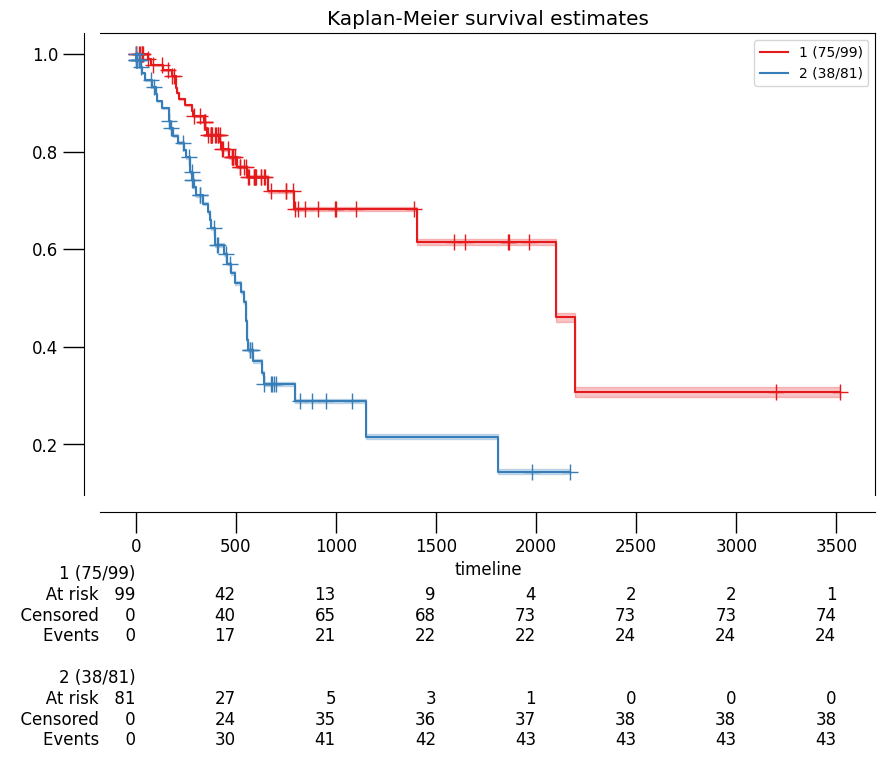

In [26]:
# Import example data
example_df = km.example_data()

# Data
time_event_example = example_df['time']
censoring_example = example_df['Died']
y_example = example_df['group']

# print(example_df)
#      time  Died  group
# 0     485     0      1
# 1     526     1      2
# 2     588     1      2
# 3     997     0      1
# 4     426     1      1
# ..    ...   ...    ...
# 175   183     0      1
# 176  3196     0      1
# 177   457     1      2
# 178  2100     1      1
# 179   376     0      1
#
# [180 rows x 3 columns]

# Compute Survival
results_example = km.fit(time_event_example, censoring_example, y_example)

# Plot
km_plot_example = km.plot(results_example, savepath='testing_example.png', title='Kaplan-Meier survival estimates', dpi=100)

In [41]:
display(df_merged_filtered)
display(df_basic_phenotype_filtered_ordered)
display(df_survival_phenotype_filtered_ordered)

,TCGA-IB-7644-01A,TCGA-77-8138-01A,TCGA-HU-A4GQ-01A,TCGA-ET-A4KN-01A,TCGA-GL-A9DE-11A,TCGA-VP-AA1N-01A,TCGA-R6-A6Y0-01B,TCGA-BQ-5888-11A,TCGA-A4-7584-01A,TARGET-15-SJMPAL004013-04A,...,TCGA-A6-6653-01A,TCGA-50-5944-01A,TCGA-EL-A4K9-01A,TCGA-CZ-4864-01A,TCGA-66-2792-01A,TCGA-VD-AA8R-01A,TCGA-AC-A3HN-01A,TCGA-EA-A3QE-01A,TCGA-AC-A62V-01A,TCGA-ZC-AAAA-01A
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,17.148837,18.773270,17.288752,17.346812,19.410539,19.025917,19.275867,18.423860,17.927576,9.005084,...,18.425429,18.845541,18.522588,17.677492,18.382500,18.247626,16.768539,17.972690,16.358954,17.247766
TNMD,9.228830,8.661236,0.000000,0.000000,11.507756,10.608419,9.329380,13.012415,8.143058,0.000000,...,10.802372,9.659687,9.119110,11.871039,0.000000,0.000000,15.792815,0.000000,12.236728,12.661648
DPM1,18.880466,19.135352,19.980100,18.379495,18.939707,19.378168,19.203570,18.998123,18.728509,18.964521,...,18.491465,19.067894,19.090572,18.859595,19.637276,18.786115,18.938820,18.632697,19.760591,19.395982
SCYL3,16.249406,15.365856,15.346060,14.711814,15.704399,15.782340,15.668592,15.646305,15.318128,16.626765,...,14.664486,16.116535,15.847110,15.866017,15.445452,15.567536,16.757410,16.169100,15.077132,16.050181
C1orf112,14.152475,15.937671,15.036143,10.374558,13.161793,13.987099,15.280625,13.149935,12.892046,16.410518,...,15.011800,14.168915,13.856022,14.060521,15.984421,13.723340,15.285292,15.056823,15.277258,15.490330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Metazoa_SRP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AJ271736.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MIR6089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,sample,program,sample_type_id,sample_type,project_id,Age at Diagnosis in Years,Gender
0,TCGA-IB-7644-01A,TCGA,1,Primary Tumor,TCGA-PAAD,65.0,Female
1,TCGA-77-8138-01A,TCGA,1,Primary Tumor,TCGA-LUSC,74.0,Male
2,TCGA-HU-A4GQ-01A,TCGA,1,Primary Tumor,TCGA-STAD,71.0,Male
3,TCGA-ET-A4KN-01A,TCGA,1,Primary Tumor,TCGA-THCA,51.0,Female
4,TCGA-GL-A9DE-11A,TCGA,11,Solid Tissue Normal,TCGA-KIRP,74.0,Male
...,...,...,...,...,...,...,...
11501,TCGA-VD-AA8R-01A,TCGA,1,Primary Tumor,TCGA-UVM,78.0,Female
11502,TCGA-AC-A3HN-01A,TCGA,1,Primary Tumor,TCGA-BRCA,87.0,Female
11503,TCGA-EA-A3QE-01A,TCGA,1,Primary Tumor,TCGA-CESC,45.0,Female
11504,TCGA-AC-A62V-01A,TCGA,1,Primary Tumor,TCGA-BRCA,58.0,Male


,sample,OS,_PATIENT,OS.time
0,TCGA-IB-7644-01A,1,TCGA-IB-7644,394
1,TCGA-77-8138-01A,1,TCGA-77-8138,539
2,TCGA-HU-A4GQ-01A,1,TCGA-HU-A4GQ,3
3,TCGA-ET-A4KN-01A,0,TCGA-ET-A4KN,1009
4,TCGA-GL-A9DE-11A,0,TCGA-GL-A9DE,496
...,...,...,...,...
11501,TCGA-VD-AA8R-01A,0,TCGA-VD-AA8R,6
11502,TCGA-AC-A3HN-01A,0,TCGA-AC-A3HN,496
11503,TCGA-EA-A3QE-01A,0,TCGA-EA-A3QE,761
11504,TCGA-AC-A62V-01A,1,TCGA-AC-A62V,348


### Real KM Rendering

---

In [130]:
import statsmodels.api as sm # for hazard ratio calculations 
import numpy as np

In [114]:
# TESTING - test user input for form fields (user-generated signature name, and gene names selected)
# ssGSEA GSVA calculation done on cancer_types_user = ['TCGA-BRCA'], stored in variables 'score'
signature = {'ecsig': ['EGFR', 'FGR']}
# Drop-down user-selected cut-point
cut_point = ["Median", "Tertile", "Tertile - Top & Bottom only", "Quartile", "Quartile - Top & Bottom only"]
# User-selected cut-point
selection = cut_point[2]
selection = selection.lower()
# # Use state sessions to get form values
# signature_name, genes_entered, cancer_types_entered, cut_point_entered = get_form_values()
signature_name='ecsig'

In [115]:
# Define the number of quantile cuts to make
if 'median' in selection:
    n = 2
    labels = ['Low: below median', 'High: above median']
if 'tertile' in selection:
    n = 3
    labels = ['Low: bottom tertile', 'Medium: middle tertile', 'High: top tertile']
if 'quartile' in selection:
    n = 4
    labels = ['Low: bottom quartile', 'Medium1: second quartile', 'Medium2: third quartile', 'High: top quartile']

# Make the quantile cuts & label samples by the scoring grouping
nes_scores = score.res2d['NES']
km_groups = pd.qcut(nes_scores, n, labels=labels)

# Bind KM groups to survival dataframe by aligning the indices of both the Series and the DataFrame
# Create a new dataframe by copying the original df
km_df = df_survival_phenotype_filtered_ordered.copy()
# Add the 'NES_group' column from km_groups to the new dataframe
km_df['NES_group'] = km_groups

# Drop any 'NES_group' null values
km_df = km_df.dropna(subset=['NES_group'])

# BUT the user might not want all groups (quantiles) on the plot (eg; top & bottom only)
if 'top' in selection:
    # Subset km_df to include only rows where 'NES_group' contains 'top' or 'bottom'
    km_df = km_df[km_df['NES_group'].str.contains('Top|Bottom', case=False)]

In [180]:
# Plot the KM plot
# Data
time_event = km_df['OS.time']
censoring = km_df['OS'] # Alive / Dead
y = km_df['NES_group']

# Compute Survival
results = km.fit(time_event, censoring, y)

# Locate P value
p_value = results['logrank_P']

# Compute hazard ratio
hazard_df = km_df.copy()
hazard_df['NES_group'] = hazard_df['NES_group'].cat.codes
cox_model = sm.PHReg(hazard_df['OS.time'], hazard_df[['NES_group']], status=hazard_df['OS'])
hazard_results = cox_model.fit()
# Locate the log hazard ratio (log HR)
log_hazard_ratio = hazard_results.params[0]
# Calculate the Hazard Ratio (HR)
hazard_ratio = np.exp(log_hr)

# Plot with P value, hazard ratio, and signature name
title = f'Kaplan-Meier survival estimates\n{signature_name}\nP={p_value}\nHR={hazard_ratio}'
km_plot = km.plot(results, title=title, dpi=300, visible=False)

# Extract the figure from the plot output
fig = km_plot[0]
# Adjust the margins
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)
# Save the plot - using bbox_inches='tight' to avoid cutting off any content
fig.savefig("mat_km_plot.png", bbox_inches='tight')